# Baseline Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling   import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc, fbeta_score
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline

In [2]:
df=pd.read_csv('u5mr_clean.csv')

In [3]:
# Make a safe working copy
df = df.copy()

# Object ID
df['CASEID'] = df['CASEID'].astype('object')

# Continuous floats
float_vars = [
    'Age in 5-year groups',
    'Birth weight in kilograms (3 decimals)',
    'Childs weight in kilograms (1 decimal)',
    'Childs height in centimeters (1 decimal)',
    'Months of breastfeeding',
    'When child put to breast',
    'Height/Age standard deviation (new WHO)',
    'Weight/Age standard deviation (new WHO)',
    'Weight/Height standard deviation (new WHO)'
]
df[float_vars] = df[float_vars].apply(pd.to_numeric, errors="coerce").astype('float64')

# Discrete ints (nullable safe type)
int_vars = [
    'Number of household members (listed)',
    'Birth order number',
    'Preceding birth interval (months)',
    'Succeeding birth interval (months)',
    'Duration of pregnancy in months',
    'Timing of 1st antenatal check (months)',
    'Number of antenatal visits during pregnancy',
    'Entries in pregnancy and postnatal care roster',
    'Minutes to nearest healthcare facility',
    'Number of tetanus injections before birth',
    'Number of tetanus injections before pregnancy'
]
df[int_vars] = df[int_vars].apply(pd.to_numeric, errors="coerce").astype('Int64')

# Categorical (nominal/ordinal)
cat_vars = [
    'Region',
    'Type of place of residence',
    'Highest educational level',
    'Religion',
    'Ethnicity',
    'Wealth index combined',
    'Type of cooking fuel (smoke exposure, indoor air pollution)',
    'Sex of child',
    'Place of delivery',
    'Size of child at birth',
    'Has health card and or other vaccination document',
    'Ever had vaccination',
    'Place where most vaccinations were received',
    'Yellow fever vaccine',
    'Currently breastfeeding',
    'Given child anything other than breast milk',
    'In contact with someone with cough or TB',
    'Source of drinking water',
    'Main floor material',
    'Visited health facility last 12 months',
    'Getting medical help for self: distance to health facility',
    'Mode of transportation to nearest healthcare facility',
]
df[cat_vars] = df[cat_vars].astype('category')

In [4]:
df.columns

Index(['CASEID', 'Age in 5-year groups', 'Region',
       'Type of place of residence', 'Highest educational level', 'Religion',
       'Ethnicity', 'Number of household members (listed)',
       'Wealth index combined',
       'Type of cooking fuel (smoke exposure, indoor air pollution)',
       ...
       'Received inactivated polio (IPV)_missing',
       'Received Rotavirus 2_missing',
       'Place where most vaccinations were received_missing',
       'Yellow fever vaccine_missing',
       'Given child anything other than breast milk_missing',
       'Visited health facility last 12 months_missing',
       'Getting medical help for self: distance to health facility_missing',
       'Mode of transportation to nearest healthcare facility_missing',
       'prenatal_help_missing', 'delivery_help_missing'],
      dtype='object', length=104)

## Feature Engineering

In [5]:
# pattern to drop all columns that end with '_missing' or contain 'vaccine'
leakage_cols = [col for col in df.columns
                if col.endswith('_missing')
                or 'vaccine' in col.lower()
                or 'Received' in col]

# explicitly drop known outcome columns
outcome_cols = [
    'under5_mortality','infant_mortality','neonatal_mortality',
    'mortality_category'
]

In [6]:
leakage_cols

['Received BCG',
 'Received POLIO 1',
 'Received POLIO 2',
 'Received POLIO 3',
 'Received POLIO 0',
 'Received MEASLES 1',
 'Received MEASLES 2',
 'Received Pentavalent 1',
 'Received Pentavalent 2',
 'Received Pentavalent 3',
 'Received Pneumococcal 1',
 'Received Pneumococcal 2',
 'Received Pneumococcal 3',
 'Received Rotavirus 1',
 'Received inactivated polio (IPV)',
 'Received Rotavirus 2',
 'Yellow fever vaccine',
 'Preceding birth interval (months)_missing',
 'Succeeding birth interval (months)_missing',
 'Timing of 1st antenatal check (months)_missing',
 'Number of antenatal visits during pregnancy_missing',
 'Birth weight in kilograms (3 decimals)_missing',
 'Ever had vaccination_missing',
 'Months of breastfeeding_missing',
 'When child put to breast_missing',
 'Minutes to nearest healthcare facility_missing',
 'Number of tetanus injections before birth_missing',
 'Number of tetanus injections before pregnancy_missing',
 'Place of delivery_missing',
 'Size of child at birth_m

In [7]:
## Handle skewed numeric features
# Log transform household size to reduce right skew
if 'Number of household members (listed)' in df.columns:
    df['log_household_size'] = np.log1p(df['Number of household members (listed)'])

In [8]:
# Socioeconomic score: combine wealth + education (if both exist and numeric/categorical)
if {'Wealth index combined','Highest educational level'}.issubset(df.columns):
    # Ensure we have numeric codes for both
    df['Wealth index combined'] = df['Wealth index combined'].astype('category').cat.codes
    df['Highest educational level'] = df['Highest educational level'].astype('category').cat.codes
    df['socioeconomic'] = (df['Wealth index combined']
                           + df['Highest educational level'])

In [9]:
# Interval features
if 'Preceding birth interval (months)' in df.columns:
    df['short_birth_interval'] = (
        df['Preceding birth interval (months)'] < 24
    ).astype(int)

In [10]:
for col in ['Ethnicity', 'Religion']:
    if col in df.columns:
        # ensure it's plain string, not Categorical
        df[col] = df[col].astype(str)

        counts = df[col].value_counts()
        rare = counts[counts < 50].index

        # replace all rare categories with "Other"
        df[col] = df[col].replace(list(rare), 'Other')


In [11]:
X = df.drop(columns=leakage_cols + outcome_cols + ['CASEID'])

In [12]:
corr = X.corr(numeric_only=True).abs()
high_corr = np.where(corr > 0.9)
pairs = [(corr.index[i], corr.columns[j])
         for i,j in zip(*high_corr)
         if i < j]
print(pairs)

[('Number of household members (listed)', 'log_household_size'), ('Wealth index combined', 'socioeconomic'), ('Childs weight in kilograms (1 decimal)', 'Childs height in centimeters (1 decimal)')]


In [13]:
# create BMI column
df['child_BMI'] = df['Childs weight in kilograms (1 decimal)'] / (
    (df['Childs height in centimeters (1 decimal)'] / 100) ** 2
)

# drop originals to avoid multicollinearity
df = df.drop(columns=[
    'Childs weight in kilograms (1 decimal)',
    'Childs height in centimeters (1 decimal)',
    'Number of household members (listed)',
    'Wealth index combined'
])
df['child_BMI'] = df['child_BMI'].round(2)

In [14]:
print("Feature engineering complete. New shape:", df.shape)

Feature engineering complete. New shape: (19530, 104)


In [15]:
df.head()

,CASEID,Age in 5-year groups,Region,Type of place of residence,Highest educational level,Religion,Ethnicity,"Type of cooking fuel (smoke exposure, indoor air pollution)",Birth order number,Sex of child,...,Given child anything other than breast milk_missing,Visited health facility last 12 months_missing,Getting medical help for self: distance to health facility_missing,Mode of transportation to nearest healthcare facility_missing,prenatal_help_missing,delivery_help_missing,log_household_size,socioeconomic,short_birth_interval,child_BMI
0,1 4 2,4.0,1.0,1.0,0,7.0,11.0,2.0,4,1.0,...,0,0,0,0,0,0,1.94591,3,0,1.92
1,1 13 2,5.0,1.0,1.0,2,1.0,3.0,2.0,5,2.0,...,1,0,0,0,1,1,2.197225,6,0,1.79
2,1 26 2,3.0,1.0,1.0,2,3.0,3.0,2.0,3,1.0,...,1,0,0,0,1,1,1.791759,5,1,1.45
3,1 42 1,4.0,1.0,1.0,2,4.0,3.0,2.0,1,2.0,...,1,1,1,1,1,1,1.386294,6,0,1.40
4,1 55 2,4.0,1.0,1.0,2,2.0,3.0,2.0,2,1.0,...,1,1,1,1,0,0,1.609438,6,1,1.69


## Baseline Logistic model

In [16]:
cat_cols = X.select_dtypes(include=['object','category']).columns
num_cols = X.select_dtypes(exclude=['object','category']).columns

In [17]:

cat_cols

Index(['Region', 'Type of place of residence', 'Religion', 'Ethnicity',
       'Type of cooking fuel (smoke exposure, indoor air pollution)',
       'Sex of child', 'Place of delivery', 'Size of child at birth',
       'Has health card and or other vaccination document',
       'Ever had vaccination', 'Place where most vaccinations were received',
       'Currently breastfeeding',
       'Given child anything other than breast milk',
       'In contact with someone with cough or TB', 'Source of drinking water',
       'Main floor material', 'Visited health facility last 12 months',
       'Getting medical help for self: distance to health facility',
       'Mode of transportation to nearest healthcare facility',
       'prenatal_help', 'delivery_help'],
      dtype='object')

In [18]:
# Preprocessing: scale numeric + one-hot encode categoricals
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

baseline_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [19]:
def baseline_logistic(X, y, target_name):
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Fit baseline model
    baseline_pipe.fit(X_train, y_train)

    # Predictions
    y_pred  = baseline_pipe.predict(X_test)
    y_proba = baseline_pipe.predict_proba(X_test)[:, 1]  # for AUC metrics

    # --- Evaluation ---
    print(f"\n--- Baseline Logistic Regression: {target_name} ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(classification_report(y_test, y_pred, digits=3))

    # F2 score
    f2 = fbeta_score(y_test, y_pred, beta=2)
    print(f"F2 Score: {f2:.3f}")

    # ROC-AUC
    roc = roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC: {roc:.3f}")

    # Precision–Recall AUC
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    print(f"PR-AUC: {pr_auc:.3f}")

    # Confusion matrix plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred 0','Pred 1'],
                yticklabels=['True 0','True 1'])
    plt.title(f"Confusion Matrix: {target_name}")
    plt.show()


--- Baseline Logistic Regression: Under-5 Mortality ---
Accuracy: 0.979
              precision    recall  f1-score   support

           0      0.987     0.991     0.989      3767
           1      0.734     0.655     0.692       139

    accuracy                          0.979      3906
   macro avg      0.861     0.823     0.841      3906
weighted avg      0.978     0.979     0.979      3906

F2 Score: 0.669
ROC-AUC: 0.988
PR-AUC: 0.737


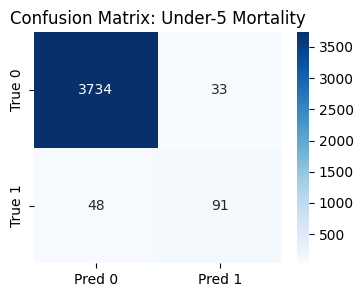


--- Baseline Logistic Regression: Infant Mortality ---
Accuracy: 0.990
              precision    recall  f1-score   support

           0      0.991     0.999     0.995      3870
           1      0.167     0.028     0.048        36

    accuracy                          0.990      3906
   macro avg      0.579     0.513     0.521      3906
weighted avg      0.983     0.990     0.986      3906

F2 Score: 0.033
ROC-AUC: 0.971
PR-AUC: 0.187


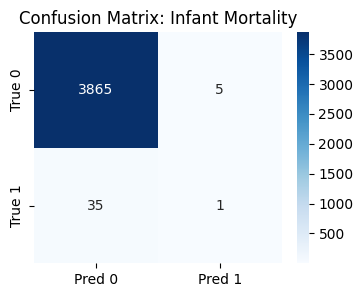


--- Baseline Logistic Regression: Neonatal Mortality ---
Accuracy: 0.984
              precision    recall  f1-score   support

           0      0.988     0.996     0.992      3819
           1      0.741     0.460     0.567        87

    accuracy                          0.984      3906
   macro avg      0.864     0.728     0.780      3906
weighted avg      0.982     0.984     0.983      3906

F2 Score: 0.498
ROC-AUC: 0.985
PR-AUC: 0.655


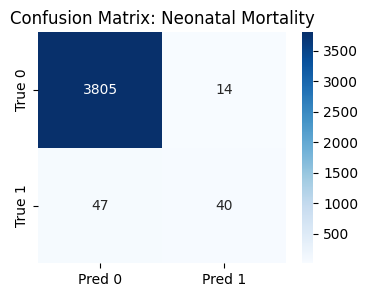

In [20]:
baseline_logistic(X, df['under5_mortality'], 'Under-5 Mortality')
baseline_logistic(X, df['infant_mortality'], 'Infant Mortality')
baseline_logistic(X, df['neonatal_mortality'], 'Neonatal Mortality')

## Logistic Regression with SMOTE

In [21]:
smote_pipe = Pipeline([
    ('preprocessor', preprocessor),      # <--- reuse the preprocessor you just built
    ('smote', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [22]:
from sklearn.metrics import average_precision_score
def logistic_with_smote(X, y, name):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    smote_pipe.fit(X_train, y_train)
    y_pred = smote_pipe.predict(X_test)
    y_prob = smote_pipe.predict_proba(X_test)[:, 1]   # probabilities for ROC/PR

    print(f"\n--- Logistic Regression + SMOTE : {name} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("F2 Score:", fbeta_score(y_test, y_pred, beta=2))
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))
    print("PR-AUC:", average_precision_score(y_test, y_prob))

In [23]:
# Run for each target
logistic_with_smote(X, df['under5_mortality'], 'Under-5 Mortality')
logistic_with_smote(X, df['infant_mortality'], 'Infant Mortality')
logistic_with_smote(X, df['neonatal_mortality'], 'Neonatal Mortality')


--- Logistic Regression + SMOTE : Under-5 Mortality ---
Accuracy: 0.9564772145417306
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      3767
           1       0.45      0.96      0.61       139

    accuracy                           0.96      3906
   macro avg       0.72      0.96      0.79      3906
weighted avg       0.98      0.96      0.96      3906

F2 Score: 0.779601406799531
ROC-AUC: 0.9881572841010441
PR-AUC: 0.6998693377442627

--- Logistic Regression + SMOTE : Infant Mortality ---
Accuracy: 0.9541730670762929
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      3870
           1       0.13      0.69      0.22        36

    accuracy                           0.95      3906
   macro avg       0.56      0.83      0.60      3906
weighted avg       0.99      0.95      0.97      3906

F2 Score: 0.37091988130563797
ROC-AUC: 0.965798162503589
PR-AUC: 0.16144678171847987

--- Lo

In [24]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import  make_scorer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

In [25]:
# --- Custom scorers focused on death detection ---
def pr_auc_score(y_true, y_prob):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    return auc(recall, precision)

f2_scorer   = make_scorer(fbeta_score, beta=2)
pr_auc_scorer = make_scorer(pr_auc_score, needs_proba=True)

In [26]:
# --- Cross-validation setup ---
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# --- Base pipeline with SMOTE inside ---
base_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42, k_neighbors=1)),  # k_neighbors=1 handles very small minority counts
    ('model', RandomForestClassifier())               # placeholder; will be overridden by param grid
])

In [27]:
# --- Parameter grid for three algorithms ---
param_grid = [
    # Random Forest
    {
        'model': [RandomForestClassifier(random_state=42)],
        'model__n_estimators': [100, 300],
        'model__max_depth': [None, 10]
    },
    # Gradient Boosting
    {
        'model': [GradientBoostingClassifier(random_state=42)],
        'model__n_estimators': [100, 300],
        'model__learning_rate': [0.1, 0.05],
        'model__max_depth': [3, 5]
    },
    # XGBoost
    {
        'model': [XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42,
            n_jobs=-1
        )],
        'model__n_estimators': [200, 400],
        'model__max_depth': [3, 5],
        'model__learning_rate': [0.1, 0.05]
    }
]

In [28]:
# --- Grid search ---
grid = GridSearchCV(
    estimator=base_pipe,
    param_grid=param_grid,
    scoring={'F2': f2_scorer, 'PR-AUC': pr_auc_scorer},
    refit='F2',        # best model chosen by F2
    cv=cv,
    n_jobs=-1,
    verbose=1
)

In [29]:
# === Function to train & evaluate for one target ===
def train_eval_model(X, y, target_name):
    grid.fit(X, y)

    print(f"\n--- Best model for {target_name} ---")
    print("Estimator:", grid.best_estimator_['model'])
    print("Best F2:", grid.best_score_)

    # Evaluate on the hold-out folds already done in CV
    # For a final external test set, split beforehand and call grid.score(X_test, y_test)

    y_pred = grid.predict(X)
    y_prob = grid.predict_proba(X)[:, 1]

    print("\nClassification Report:")
    print(classification_report(y, y_pred, digits=3))
    print("Accuracy:", accuracy_score(y, y_pred))
    print("ROC-AUC:", roc_auc_score(y, y_prob))
    precision, recall, _ = precision_recall_curve(y, y_prob)
    print("PR-AUC:", auc(recall, precision))

    # Confusion matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred 0','Pred 1'],
                yticklabels=['True 0','True 1'])
    plt.title(f"Confusion Matrix: {target_name}")
    plt.show()

Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\user\anaconda3\envs\new-env\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(



--- Best model for Under-5 Mortality ---
Estimator: RandomForestClassifier(max_depth=10, n_estimators=300, random_state=42)
Best F2: 0.9810646940887243

Classification Report:
              precision    recall  f1-score   support

           0      1.000     0.996     0.998     18836
           1      0.912     1.000     0.954       694

    accuracy                          0.997     19530
   macro avg      0.956     0.998     0.976     19530
weighted avg      0.997     0.997     0.997     19530

Accuracy: 0.9965693804403482
ROC-AUC: 0.9995215030632985
PR-AUC: 0.9843279452227202


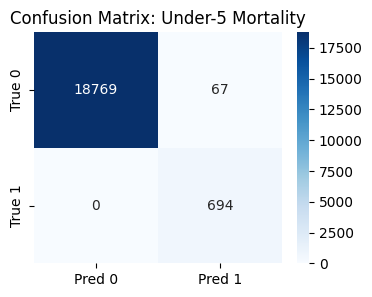

Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\user\anaconda3\envs\new-env\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(



--- Best model for Infant Mortality ---
Estimator: GradientBoostingClassifier(learning_rate=0.05, random_state=42)
Best F2: 0.6514557527134496

Classification Report:
              precision    recall  f1-score   support

           0      1.000     0.977     0.988     19350
           1      0.287     0.994     0.446       180

    accuracy                          0.977     19530
   macro avg      0.644     0.986     0.717     19530
weighted avg      0.993     0.977     0.983     19530

Accuracy: 0.9772145417306708
ROC-AUC: 0.9931688199827735
PR-AUC: 0.5070290701881448


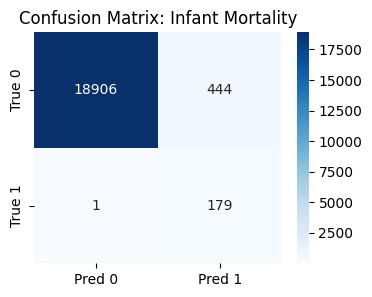

Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\user\anaconda3\envs\new-env\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(



--- Best model for Neonatal Mortality ---
Estimator: RandomForestClassifier(max_depth=10, n_estimators=300, random_state=42)
Best F2: 0.8709581586372175

Classification Report:
              precision    recall  f1-score   support

           0      1.000     0.983     0.991     19093
           1      0.574     1.000     0.730       437

    accuracy                          0.983     19530
   macro avg      0.787     0.992     0.860     19530
weighted avg      0.990     0.983     0.986     19530

Accuracy: 0.9834101382488479
ROC-AUC: 0.9981540433007604
PR-AUC: 0.9200818925538592


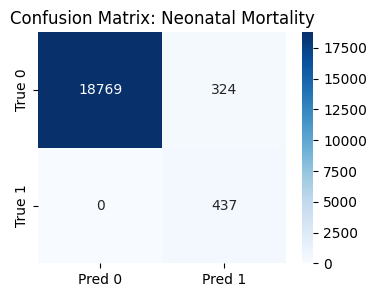

In [30]:
train_eval_model(X, df['under5_mortality'], 'Under-5 Mortality')
train_eval_model(X, df['infant_mortality'], 'Infant Mortality')
train_eval_model(X, df['neonatal_mortality'], 'Neonatal Mortality')

## Neural network